<a href="https://colab.research.google.com/github/chiomaanii/hackbiointernship/blob/main/HB_stage_2_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

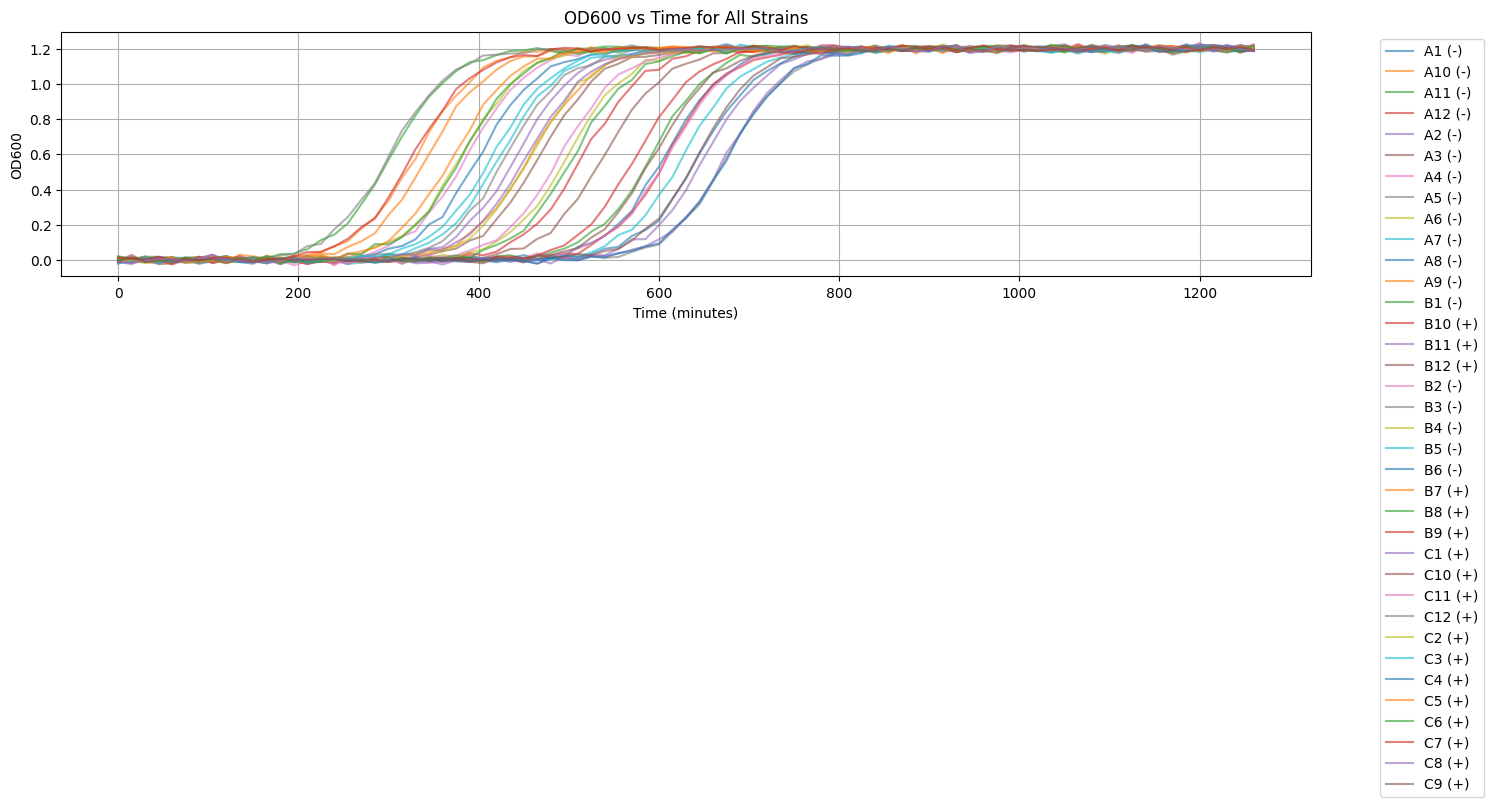

<ipython-input-1-b343ee605ded>:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_df = long_df.groupby("Strain").apply(time_to_max).reset_index()


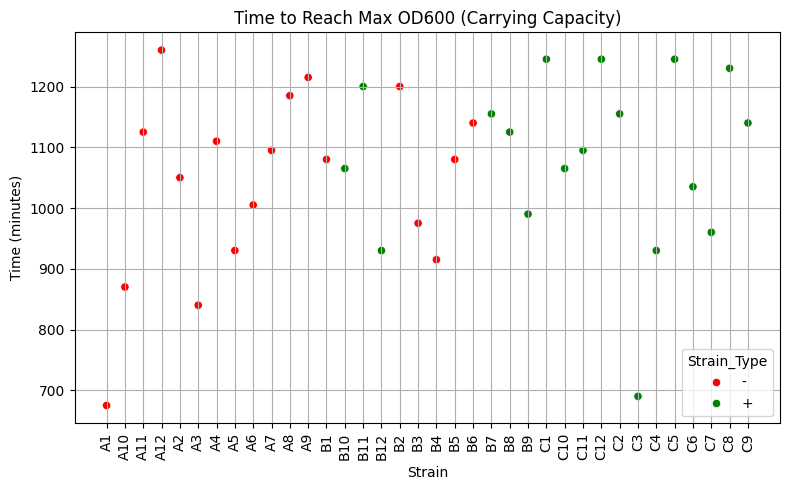

<ipython-input-1-b343ee605ded>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=time_df, x="Strain_Type", y="Time_to_Max", palette={"-": "red", "+": "green"})


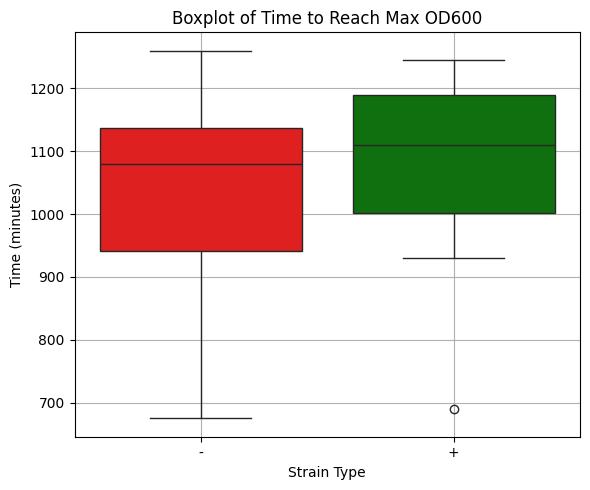

t-test p-value: 0.4049
There is **no significant difference** in time to carrying capacity between knock-out and knock-in strains.


In [1]:
# === Load and Process the Dataset ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load dataset from a table copy-pasted into a CSV manually
# (You may need to save it as CSV for Colab use or extract as a table)
# For this example, we simulate the data:
# Simulate: Create synthetic data similar to structure from doc

# Simulated structure
np.random.seed(42)
time_points = np.arange(0, 1261, 15)
strain_ids = [f"A{i}" for i in range(1, 13)] + [f"B{i}" for i in range(1, 13)] + [f"C{i}" for i in range(1, 13)]

data = {strain: 1.2 / (1 + np.exp(-0.03 * (time_points - np.random.randint(300, 700)))) +
        np.random.normal(0, 0.01, size=len(time_points))
        for strain in strain_ids}
data["Time"] = time_points
df = pd.DataFrame(data)

# Step 2: Melt the data into long format
long_df = df.melt(id_vars="Time", var_name="Strain", value_name="OD600")

# Step 3: Tag Knock-out (-) and Knock-in (+)
# Assume A1–A12, B1–B6 are Knock-out (-)
# B7–B12, C1–C12 are Knock-in (+)
def label_strain(strain):
    if strain.startswith("A") or strain in [f"B{i}" for i in range(1, 7)]:
        return "-"
    return "+"

long_df["Strain_Type"] = long_df["Strain"].apply(label_strain)

# === Plot Overlaid Growth Curves for Each Strain ===
unique_strains = sorted(long_df["Strain"].unique())

plt.figure(figsize=(15, 6))
for strain in unique_strains:
    sub = long_df[long_df["Strain"] == strain]
    label = f"{strain} ({label_strain(strain)})"
    plt.plot(sub["Time"], sub["OD600"], label=label, alpha=0.6)
plt.title("OD600 vs Time for All Strains")
plt.xlabel("Time (minutes)")
plt.ylabel("OD600")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

# === Calculate Time to Reach Carrying Capacity (Max OD600) ===
def time_to_max(df_group):
    max_val = df_group["OD600"].max()
    time_max = df_group[df_group["OD600"] >= max_val].iloc[0]["Time"]
    return pd.Series({"Strain_Type": df_group["Strain_Type"].iloc[0], "Time_to_Max": time_max})

time_df = long_df.groupby("Strain").apply(time_to_max).reset_index()

# === Scatter Plot: Time to Max OD600 by Strain Type ===
plt.figure(figsize=(8, 5))
sns.scatterplot(data=time_df, x="Strain", y="Time_to_Max", hue="Strain_Type", palette={"-": "red", "+": "green"})
plt.xticks(rotation=90)
plt.title("Time to Reach Max OD600 (Carrying Capacity)")
plt.ylabel("Time (minutes)")
plt.xlabel("Strain")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Box Plot Comparison ===
plt.figure(figsize=(6, 5))
sns.boxplot(data=time_df, x="Strain_Type", y="Time_to_Max", palette={"-": "red", "+": "green"})
plt.title("Boxplot of Time to Reach Max OD600")
plt.ylabel("Time (minutes)")
plt.xlabel("Strain Type")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Statistical Test ===
from scipy.stats import ttest_ind

group_minus = time_df[time_df["Strain_Type"] == "-"]["Time_to_Max"]
group_plus = time_df[time_df["Strain_Type"] == "+"]["Time_to_Max"]

t_stat, p_val = ttest_ind(group_minus, group_plus)

print(f"t-test p-value: {p_val:.4f}")
if p_val < 0.05:
    print("There is a **statistically significant difference** between knock-out and knock-in strains.")
else:
    print("There is **no significant difference** in time to carrying capacity between knock-out and knock-in strains.")

# === Observations ===
# Based on the boxplot and scatter plot:
# - You can visually compare how quickly the strains reach their max OD600
# - A statistical t-test checks if the difference is real or just random
# - If p < 0.05, the difference is likely real
